## Accessing Sentinel-3 OLCI Water data with the Planetary Computer STAC API

### Data Access

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key. If you are using the [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) to run this notebook, then your API key is automatically set to the environment variable `PC_SDK_SUBSCRIPTION_KEY` for you when your server is started. Otherwise, you can view your keys by signing in to the [developer portal](https://planetarycomputer.developer.azure-api.net/). The API key may be manually set via the environment variable `PC_SDK_SUBSCRIPTION_KEY` or the following code:

```python
import planetary_computer
planetary_computer.settings.set_subscription_key(<YOUR API Key>)
```

The datasets hosted by the Planetary Computer are available in [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.


### Define the area of interest and search the collection

We'll search for items over the coordintes `[-2.79, 44.14]`.

In [1]:
import pystac_client
import planetary_computer
import xarray as xr
import fsspec

catalog = pystac_client.Client.open(
    "https://pct-apis-staging.westeurope.cloudapp.azure.com/stac/",
    modifier=planetary_computer.sign_inplace,
)

search = catalog.search(
    collections=["sentinel-3-olci-wfr-l2-netcdf"],
    intersects={"type": "Point", "coordinates": [-2.79, 44.14]},
)
item = next(search.items())

### Available Assets and Metadata

Each item includes a handful of assets linking to NetCDF files with the data or additional metadata files.

In [2]:
import rich.table

t = rich.table.Table("Key", "Value")
for key, asset in item.assets.items():
    t.add_row(key, asset.title)

t

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key               ┃ Value                                      ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ iwv               │ Integrated water vapour column             │
│ par               │ Photosynthetically Active Radiation        │
│ trsp              │ Transparency properties of water           │
│ wAer              │ Aerosol Over Water                         │
│ wqsf              │ Water Quality and Science Flags            │
│ chlNn             │ Neural Net Chlorophyll concentration       │
│ iopNn             │ Inherent Optical Properties of water       │
│ tsmNn             │ Total suspended matter concentration       │
│ chlOc4me          │ OC4Me algorithm Chlorophyll concentration  │
│ tieMeteo          │ Tie-Point Meteo Annotations                │
│ safe-manifest     │ SAFE product manifest                      │
│ tieGeometries     │ Tie-Point Geometries Annotations           │
│ geoCoordinates    │ Geo Coordinates Annotations                │
│ instrumentData    │ Instrument Annotation                      │
│ timeCoordinates   │ Time Coordinates Annotations               │
│ Oa01_reflectance  │ Reflectance for OLCI acquisition band Oa01 │
│ Oa02_reflectance  │ Reflectance for OLCI acquisition band Oa02 │
│ Oa03_reflectance  │ Reflectance for OLCI acquisition band Oa03 │
│ Oa04_reflectance  │ Reflectance for OLCI acquisition band Oa04 │
│ Oa05_reflectance  │ Reflectance for OLCI acquisition band Oa05 │
│ Oa06_reflectance  │ Reflectance for OLCI acquisition band Oa06 │
│ Oa07_reflectance  │ Reflectance for OLCI acquisition band Oa07 │
│ Oa08_reflectance  │ Reflectance for OLCI acquisition band Oa08 │
│ Oa09_reflectance  │ Reflectance for OLCI acquisition band Oa09 │
│ Oa10_reflectance  │ Reflectance for OLCI acquisition band Oa10 │
│ Oa11_reflectance  │ Reflectance for OLCI acquisition band Oa11 │
│ Oa12_reflectance  │ Reflectance for OLCI acquisition band Oa12 │
│ Oa16_reflectance  │ Reflectance for OLCI acquisition band Oa16 │
│ Oa17_reflectance  │ Reflectance for OLCI acquisition band Oa17 │
│ Oa18_reflectance  │ Reflectance for OLCI acquisition band Oa18 │
│ Oa21_reflectance  │ Reflectance for OLCI acquisition band Oa21 │
│ tieGeoCoordinates │ Tie-Point Geo Coordinate Annotations       │
└───────────────────┴────────────────────────────────────────────┘

### Reading data

We can use xarray to read each NetCDF file directly from Blob Storage.

In [3]:
keys = [
    "iwv",
    "par",
    "trsp",
    "wAer",
    "chlNn",
    "iopNn",
    "tsmNn",
    "chlOc4me",
    "Oa01_reflectance",
]
datasets = [xr.open_dataset(fsspec.open(item.assets[k].href).open()) for k in keys]

ds = xr.combine_by_coords(datasets, join="exact", combine_attrs="drop_conflicts")
ds

<xarray.Dataset>
Dimensions:               (rows: 4090, columns: 4865)
Dimensions without coordinates: rows, columns
Data variables: (12/20)
    A865                  (rows, columns) float32 ...
    A865_err              (rows, columns) float32 ...
    T865                  (rows, columns) float32 ...
    T865_err              (rows, columns) float32 ...
    ADG443_NN             (rows, columns) float32 ...
    ADG443_NN_err         (rows, columns) float32 ...
    ...                    ...
    Oa01_reflectance      (rows, columns) float32 ...
    Oa01_reflectance_err  (rows, columns) float32 ...
    PAR                   (rows, columns) float32 ...
    PAR_err               (rows, columns) float32 ...
    TSM_NN                (rows, columns) float32 ...
    TSM_NN_err            (rows, columns) float32 ...
Attributes: (12/15)
    absolute_orbit_number:  8893
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                ops@eumetsat.int
    creation_time:          2017-11-02T18:06:45Z
    ...                     ...
    product_name:           S3A_OL_2_WFR____20171101T101637_20171101T101937_2...
    references:             S3IPF PDS 004 - i2r1 - Product Data Format Specif...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-2 06.10
    start_time:             2017-11-01T10:16:37.146370Z
    stop_time:              2017-11-01T10:19:37.067399Z

We'll plot the integrated water vapor variable.

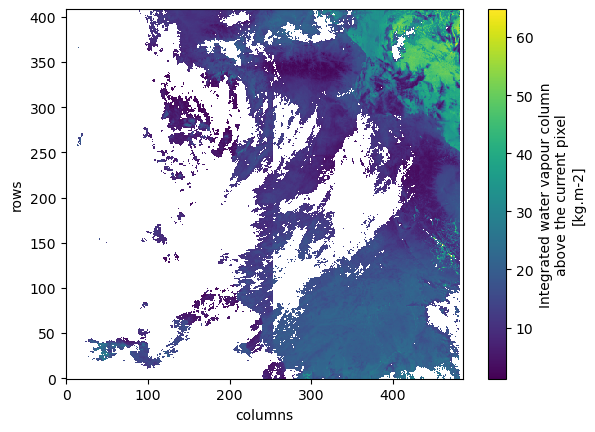

In [4]:
ds.IWV.coarsen({"rows": 10, "columns": 10}, boundary="trim").mean().plot();

### Geolocating the data

The geospatial information in this dataset is distributed as a separate NetCDF file, cataloged under the `geoCoordinates` key. That contains a dataset with `latitude` and `longitude` arrays, each of which is the same shape as the data variables and gives the latitude and longitude for each pixel in data variable.

We'll reshape the data to a (long-form) DataFrame with a single row for each pixel. We'll then make a scatter plot, using the longitude and latitude as the `x` and `y` coordintes.

In [5]:
import pandas as pd
import datashader
import colorcet

geo = xr.open_dataset(fsspec.open(item.assets["geoCoordinates"].href).open()).load()
a01 = ds.Oa01_reflectance.load()


df = pd.DataFrame(
    {
        "longitude": geo.longitude.data.ravel(),
        "latitude": geo.latitude.data.ravel(),
        "value": a01.data.ravel(),
    }
)

To avoid overplotting the data, we'll use [datashader](https://datashader.org/).

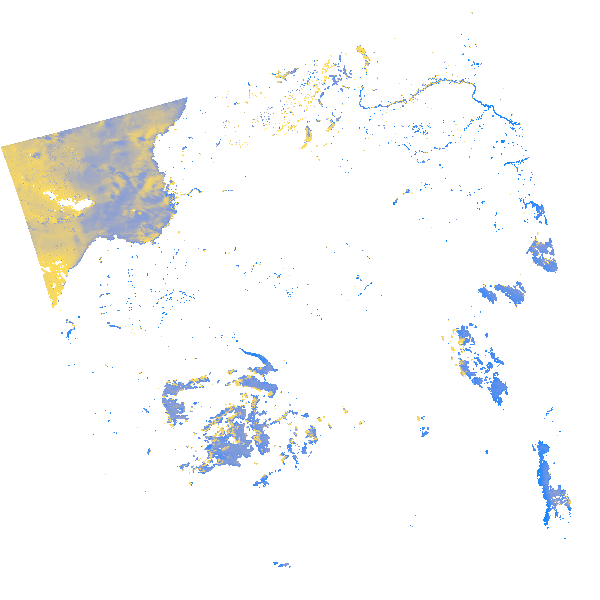

In [6]:
cvs = datashader.Canvas(plot_width=600, plot_height=600)
agg = cvs.points(df, "latitude", "longitude", agg=datashader.reductions.mean("value"))
img = datashader.tf.shade(agg, cmap=colorcet.CET_CBD2)
img